# Energy consumption prediction

## Import modules

In [ ]:
import shap
import time
import mlflow
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from source.constants import MLFLOW_TRACKING_URI
from source.helpers import load_data, split_features_target

%load_ext autoreload
%autoreload 2

In [5]:
mlflow.set_tracking_uri(f"file://{MLFLOW_TRACKING_URI}")
shap.initjs()

## Load and preprocess data

In [ ]:
df_train, df_test = load_data()

In [9]:
df_train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


##### Because the data set is big, with MLFlow, the produced files will be too large to be able to upload to the GitHub repository, here we will select the first 1000 instances of the training data set to train the model. Thus, the performance of our model will not be as good as one trained with full data set.

In [ ]:
X, y = split_features_target(df_train)
X.drop("id", axis=1, inplace=True)
X.fillna(0, inplace=True)

### Perform train-test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [12]:
categorical_cols = X_train.select_dtypes(include='object').columns
numerical_cols = X_train.drop(columns=categorical_cols).columns

## Models building
### Random Forest Tree Model

##### Because we have repeated patterns in numerical features. We decided to use random forest tree model. The random forest tree model can help us determine the importance of these features in the mean time of prediction.

In [13]:
estimator = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

In [19]:
def train_validate(pipe, _X_train, _y_train, _X_test, _y_test):
    with mlflow.start_run():
        pipe.fit(_X_train, _y_train)

        train_score = pipe.score(_X_train, _y_train)
        test_score = pipe.score(_X_test, _y_test)
        
        print(f"Train R2-Score: {train_score}")
        print(f"Test R2-Score: {test_score}")

        mlflow.log_metric("Train R2-Score", train_score)
        mlflow.log_metric("Test R2-Score", test_score)
        mlflow.log_params(estimator.get_params(deep=True))

In [ ]:
X_train_num, X_test_num = X_train[numerical_cols], X_test[numerical_cols]
train_validate(estimator, X_train_num, y_train, X_test_num, y_test)

In [23]:
def compute_rmsle(y_test: np.ndarray, y_pred: np.ndarray, precision: int = 2) -> float:
  rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
  return round(rmsle, precision)

In [61]:
def train_estimator(estimator, _X_train, _y_train, _X_test, _y_test):
    with mlflow.start_run():
        estimator.fit(_X_train[numerical_cols].fillna(0), _y_train)
        
        y_pred = estimator.predict(_X_test[numerical_cols].fillna(0))
        mse = mean_squared_error(_y_test, y_pred)
        rmsle = compute_rmsle(_y_test, y_pred)
        
        explainer = shap.TreeExplainer(estimator)
        shap_values = explainer.shap_values(X_test_num, _y_test, approximate=True)
        
        plt.figure()
        shap.summary_plot(shap_values, X_test_num, plot_type='bar')
        summary_plot1 = plt.gcf()
        time.sleep(1)
        summary_plot1.savefig('shap_summary_plot1.png')
        plt.show()
        
        plt.figure()
        shap.summary_plot(shap_values, X_test_num)
        summary_plot2 = plt.gcf()
        time.sleep(1)
        summary_plot2.savefig('shap_summary_plot2.png')
        plt.show()
        
        plt.figure()
        observation_idx = 0
        force_plot = shap.force_plot(
            base_value=explainer.expected_value, 
            shap_values=shap_values[observation_idx, :], 
            features=X_test_num.iloc[observation_idx, :], 
            matplotlib=True,
            show=False
        )
        
        mlflow.sklearn.log_model(estimator, 'estimator')
        mlflow.log_metrics({"testing_mse": mse, "testing_rmsle": rmsle})
        mlflow.log_artifact('shap_summary_plot1.png')
        mlflow.log_artifact('shap_summary_plot2.png')
        mlflow.shap.log_explanation(force_plot, artifact_path="my_force_plot")

In [ ]:
_ = train_estimator(estimator, X_train, y_train, X_test, y_test)

## SHAP Model interpretation

In [38]:
explainer = shap.TreeExplainer(estimator)
shap_values = explainer.shap_values(X_test_num, y_test, approximate=True)

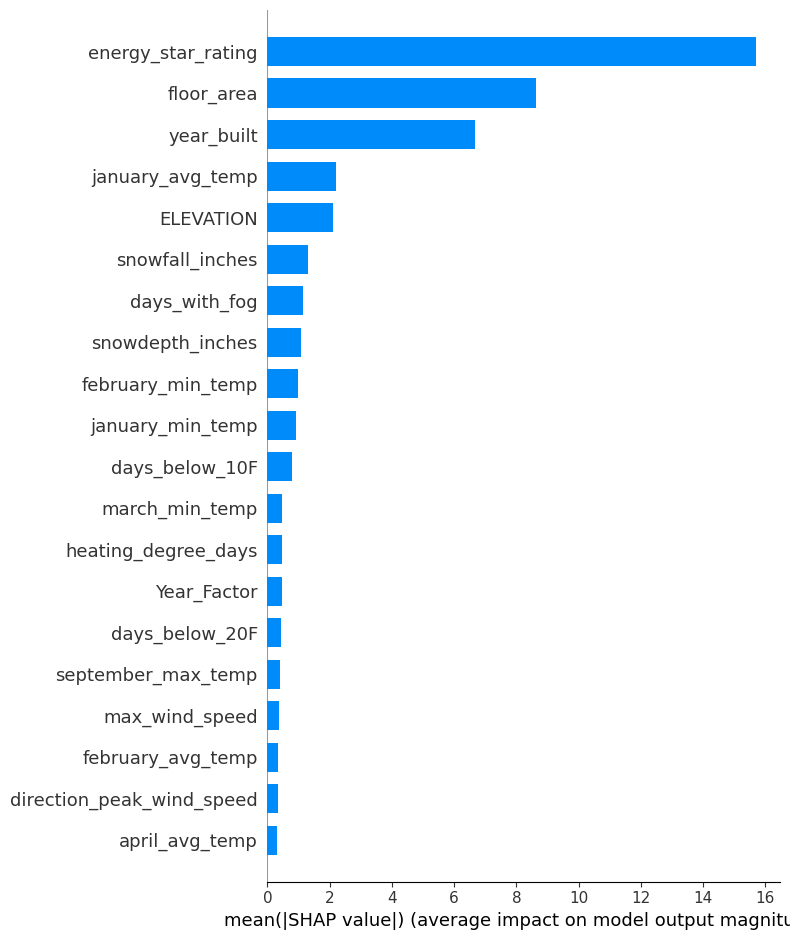

In [39]:
shap.summary_plot(shap_values, X_test_num, plot_type="bar")

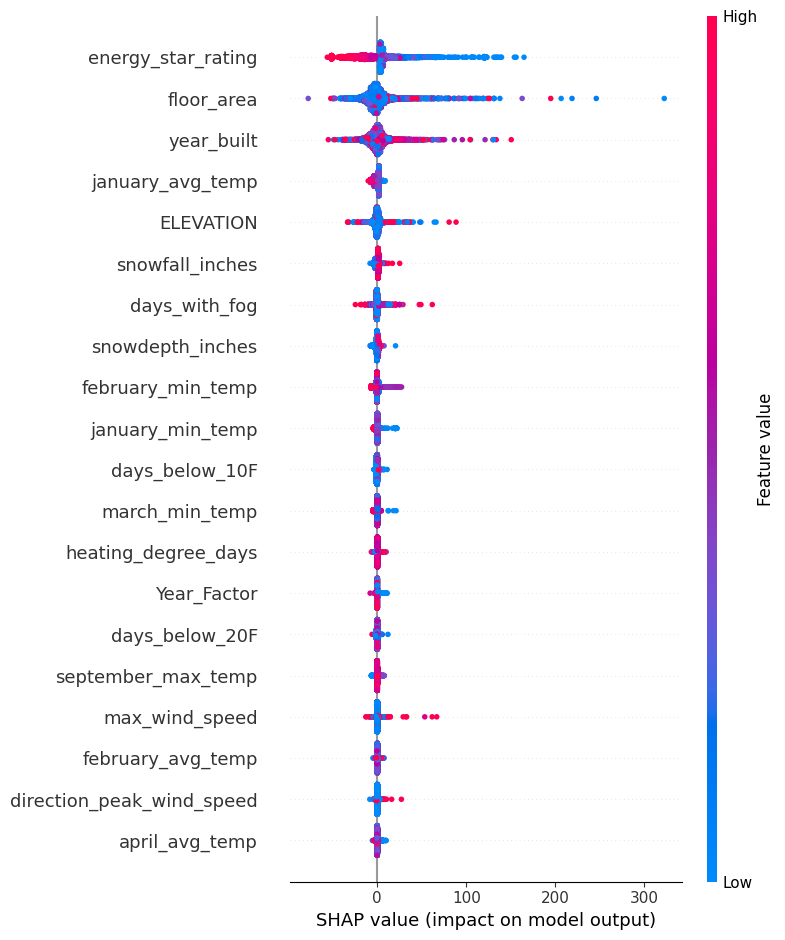

In [40]:
shap.summary_plot(shap_values, X_test_num)

In [42]:
observation_idx = 0
shap.force_plot(explainer.expected_value, shap_values[observation_idx, :], X_test_num.iloc[observation_idx, :])